In [ ]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk import PorterStemmer
from wordcloud import WordCloud,ImageColorGenerator
from PIL import Image
import urllib
import requests
#from Preprocessing import clean_text, remove_names, entity_recognizing, remove_url
from keras_preprocessing.sequence import pad_sequences
from keras_preprocessing.text import Tokenizer
from keras import Sequential
from keras.layers import Embedding
from keras.layers import SpatialDropout1D
from keras.layers import LSTM
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.regularizers import l2
import re
import os

%matplotlib inline
print(tf.__version__)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
2.4.1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# New Section

In [ ]:
path = "drive/MyDrive/IAS/NLP_and_Web/data/all_movies.csv"
df_training = pd.read_csv(path, index_col=0)
df_training.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10688 entries, 0 to 10687
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   movie_id         10688 non-null  object
 1   batch_id         10688 non-null  int64 
 2   majority_answer  10688 non-null  int64 
 3   text             10688 non-null  object
 4   movie_name       10688 non-null  object
dtypes: int64(2), object(3)
memory usage: 501.0+ KB


In [ ]:

df_training = df_training.rename(columns={'majority_answer': 'label'})

In [ ]:
df_training.head()


,movie_id,batch_id,label,text,movie_name
0,AmericanHistoryX(1998)_1,1566624979,0,Derek.,AmerricanHistoryX
1,AmericanHistoryX(1998)_2,1566624979,1,What the fuck are you thinking?,AmerricanHistoryX
2,AmericanHistoryX(1998)_3,1566624979,0,There's a black guy outside breaking into your...,AmerricanHistoryX
3,AmericanHistoryX(1998)_4,1566624979,0,How long has he been there?,AmerricanHistoryX
4,AmericanHistoryX(1998)_5,1566624979,0,I don't know.,AmerricanHistoryX


In [ ]:
df_training[df_training['movie_name'] == 'South_Park'].label.value_counts()

0    890
1    145
2     11
Name: label, dtype: int64

0    9014
1    1380
2     294
Name: label, dtype: int64


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f446db78b50>],
      dtype=object)

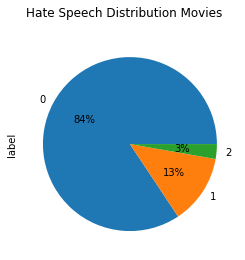

In [ ]:
#Normal:0 , Offensive:1, Hate:2
print(df_training.label.value_counts())
df_training.label.value_counts().plot(kind='pie', subplots=True, autopct='%1.0f%%', title='Hate Speech Distribution Movies')

In [ ]:
movie_names = df_training.movie_name.unique()
movie_names

array(['AmerricanHistoryX', 'BlacKkKlansman', 'Django_Unchained',
       'Pulp_Fiction', 'South_Park', 'TheWolfofWallStreet'], dtype=object)

## class label for majority of CF users. 0 - normal, 1 - offensive language, 2 - hate

In [ ]:
TEXT_COLUMN = "text"
LABEL_COLUMN = "label"

print("Converting to lower-case")
df_training[TEXT_COLUMN] = df_training[TEXT_COLUMN].str.lower()
df_training.head()

Converting to lower-case


,movie_id,batch_id,label,text,movie_name
0,AmericanHistoryX(1998)_1,1566624979,0,derek.,AmerricanHistoryX
1,AmericanHistoryX(1998)_2,1566624979,1,what the fuck are you thinking?,AmerricanHistoryX
2,AmericanHistoryX(1998)_3,1566624979,0,there's a black guy outside breaking into your...,AmerricanHistoryX
3,AmericanHistoryX(1998)_4,1566624979,0,how long has he been there?,AmerricanHistoryX
4,AmericanHistoryX(1998)_5,1566624979,0,i don't know.,AmerricanHistoryX


In [ ]:
df_training['doc_len'] = df_training[TEXT_COLUMN].apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(df_training['doc_len'].mean() + df_training['doc_len'].std()).astype(int)

In [ ]:
df_training.head()

,movie_id,batch_id,label,text,movie_name,doc_len
0,AmericanHistoryX(1998)_1,1566624979,0,derek.,AmerricanHistoryX,1
1,AmericanHistoryX(1998)_2,1566624979,1,what the fuck are you thinking?,AmerricanHistoryX,6
2,AmericanHistoryX(1998)_3,1566624979,0,there's a black guy outside breaking into your...,AmerricanHistoryX,9
3,AmericanHistoryX(1998)_4,1566624979,0,how long has he been there?,AmerricanHistoryX,6
4,AmericanHistoryX(1998)_5,1566624979,0,i don't know.,AmerricanHistoryX,3


## Splitting the data

In [ ]:
def split_dataset(df, test_movie, seed):
    test = df[df.movie_name == test_movie]
    train = df[df.movie_name != test_movie]
    train = train.sample(frac=1, random_state=seed)
    return train.text.values, train.label.values, test.text.values, test.label.values

In [ ]:
seed = 11
#test_size = 0.2
categories = [0,1,2]
movie_index = 5 #change the index to test on each movie and train on remaining 5movies
test_movie = movie_names[movie_index]
print(test_movie)

TheWolfofWallStreet


In [ ]:
train, train_targets, test, test_targets = split_dataset(df_training, test_movie,seed=seed)

In [ ]:
print(len(train))
print(len(test))

7625
3063


In [ ]:
def calculate_dataset_class_distribution(targets, categories):
    df = pd.DataFrame({'category':targets})
    s = df.category.value_counts(normalize=True)
    s = s.reindex(categories)
    return [s.index[0], s[0]], [s.index[1], s[1]], [s.index[2], s[2]]

In [ ]:
train_class_distribution = calculate_dataset_class_distribution(train_targets, categories)
test_class_distribution = calculate_dataset_class_distribution(test_targets, categories)
print(train_class_distribution)
print(test_class_distribution)

([0, 0.8577049180327869], [1, 0.104], [2, 0.03829508196721312])
([0, 0.8077048645119165], [1, 0.19164218086842966], [2, 0.000652954619653934])


In [ ]:
embed_size = 300  # how big is each word vector
max_features = None  # how many unique words to use (i.e num rows in embedding vector)
maxlen = max_seq_len  # max number of words in a question to use #99.99%

def encode(train_data, test_data, train_label, test_label):
    total_data = list(train_data)+list(test_data)
    # Tokenize the sentences
    tokenizer = Tokenizer(num_words=max_features, filters='')
    tokenizer.fit_on_texts(total_data)
    X_train = tokenizer.texts_to_sequences(train_data)
    X_test = tokenizer.texts_to_sequences(test_data)


    vocab_size = len(tokenizer.word_index) + 1
    print(tokenizer.word_index)
    
    # Pad the sentences
    X_train = pad_sequences(X_train, maxlen=maxlen)
    print(X_train.shape)
    X_test = pad_sequences(X_test, maxlen=maxlen)
    print(X_test.shape)
    
    # Get the target values
    y_train = pd.get_dummies(train_label)
    y_test = pd.get_dummies(test_label)
    print(y_train.shape)
    print(y_test.shape)
    
    return X_train, X_test,y_train, y_test,vocab_size
    

In [ ]:
len(list(train)+list(test))

10688

In [ ]:
# FETCH DATA, LABELS, DICTIONARIES
X_train, X_test, y_train, y_test, vocab_size = encode(train,test, train_targets, test_targets)
#X_test, y_test, vocab_size = encode(test, test_targets)

print(vocab_size)

{'you': 1, 'the': 2, '-': 3, 'i': 4, 'a': 5, 'to': 6, 'and': 7, 'of': 8, 'that': 9, 'in': 10, 'is': 11, 'this': 12, 'my': 13, 'your': 14, 'what': 15, 'it': 16, 'we': 17, "i'm": 18, "don't": 19, 'fucking': 20, 'all': 21, 'get': 22, 'for': 23, 'be': 24, 'on': 25, "it's": 26, 'with': 27, 'do': 28, 'me': 29, 'was': 30, 'are': 31, 'he': 32, 'like': 33, 'not': 34, 'have': 35, 'just': 36, 'got': 37, 'know': 38, 'but': 39, 'gonna': 40, 'they': 41, "you're": 42, "that's": 43, 'come': 44, 'about': 45, 'at': 46, 'out': 47, 'if': 48, 'you.': 49, 'so': 50, 'can': 51, 'fuck': 52, 'oh,': 53, 'it.': 54, 'up': 55, 'want': 56, 'go': 57, 'one': 58, 'how': 59, 'well,': 60, 'no': 61, 'think': 62, 'right': 63, 'you,': 64, 'no,': 65, 'who': 66, 'our': 67, 'his': 68, 'yeah,': 69, 'as': 70, 'yeah.': 71, 'some': 72, 'there': 73, 'when': 74, 'from': 75, 'or': 76, 'take': 77, 'me.': 78, 'now': 79, 'good': 80, 'her': 81, 'see': 82, 'an': 83, 'say': 84, 'little': 85, 'did': 86, 'black': 87, 'will': 88, 'him': 89, '

In [ ]:
y_train

,0,1,2
0,1,0,0
1,0,1,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
7620,1,0,0
7621,1,0,0
7622,1,0,0
7623,1,0,0


In [ ]:
X_train.shape

(7625, 18)

Loading the Movies dataset and preparing the encodings for each utterences

## Creating the model

In [ ]:
# model = Sequential()
# model.add(Embedding(vocab_size, embed_size, input_length=X_train.shape[1]))
# model.add(SpatialDropout1D(0.2))
# model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
# model.add(Dense(1, activation='softmax'))
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 8
batch_size = 32
lr = 0.001


model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embed_size, input_length=X_train.shape[1]),
        tf.keras.layers.LSTM(64, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)),
        tf.keras.layers.Dense(3, activation = 'softmax')
  ])

model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=lr),
                loss='categorical_crossentropy',
                metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])


In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 18, 300)           3849600   
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 195       
Total params: 3,943,235
Trainable params: 3,943,235
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, 
      epochs=epochs,  
      verbose=1, 
      validation_split=0.25,
      batch_size=batch_size)

Epoch 1/8
179/179 [==============================] - 15s 70ms/step - loss: 2.6479 - accuracy: 0.8601 - precision_8: 0.8358 - recall_8: 0.6854 - val_loss: 0.9315 - val_accuracy: 0.8490 - val_precision_8: 0.8583 - val_recall_8: 0.8448
Epoch 2/8
179/179 [==============================] - 12s 66ms/step - loss: 0.7679 - accuracy: 0.8886 - precision_8: 0.9100 - recall_8: 0.8661 - val_loss: 0.6930 - val_accuracy: 0.8951 - val_precision_8: 0.9151 - val_recall_8: 0.8757
Epoch 3/8
179/179 [==============================] - 12s 66ms/step - loss: 0.5079 - accuracy: 0.9338 - precision_8: 0.9484 - recall_8: 0.9171 - val_loss: 0.5884 - val_accuracy: 0.8888 - val_precision_8: 0.9060 - val_recall_8: 0.8794
Epoch 4/8
179/179 [==============================] - 12s 66ms/step - loss: 0.3594 - accuracy: 0.9481 - precision_8: 0.9554 - recall_8: 0.9424 - val_loss: 0.5046 - val_accuracy: 0.8915 - val_precision_8: 0.9025 - val_recall_8: 0.8836
Epoch 5/8
179/179 [==============================] - 12s 66ms/step -

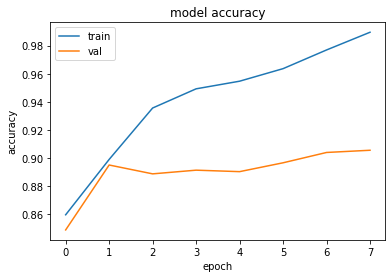

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

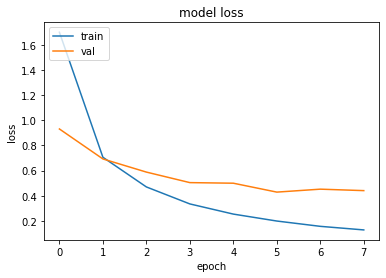

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
loss, accuracy, precision, recall = model.evaluate(X_test, y_test,batch_size=32)
print("loss: %s accuracy: %s precision: %s recall: %s" % (loss, accuracy, precision, recall))

df_evaluation = pd.DataFrame({'loss':loss, 'accuracy':accuracy, 'precision': precision, 'recall':recall},index=[0])

96/96 [==============================] - 1s 6ms/step - loss: 0.3589 - accuracy: 0.9216 - precision_8: 0.9249 - recall_8: 0.9122
loss: 0.35890069603919983 accuracy: 0.92164546251297 precision: 0.924859344959259 recall: 0.9121776223182678


In [ ]:
Y_pred = model.predict(X_test)
Y_pred.shape

(3063, 3)

In [ ]:
Y_pred

array([[8.66706908e-01, 1.12897865e-01, 2.03953013e-02],
       [9.77124751e-01, 1.83070898e-02, 4.56819916e-03],
       [9.98834550e-01, 9.82085243e-04, 1.83399723e-04],
       ...,
       [9.84902084e-01, 1.34952553e-02, 1.60267833e-03],
       [9.91060317e-01, 7.83518516e-03, 1.10453006e-03],
       [9.98787940e-01, 1.06305163e-03, 1.49030006e-04]], dtype=float32)

In [ ]:
Y_pred = np.argmax(Y_pred, axis=1)
Y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
test_targets.shape

(3063,)

In [ ]:
categories = ['normal', 'offensive', 'hate']
 
report = classification_report(test_targets, Y_pred, target_names=categories, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
normal,0.917102,0.992724,0.953416,2474.000000
offensive,0.953247,0.625213,0.755144,587.000000
hate,0.000000,0.000000,0.000000,2.000000
accuracy,0.921645,0.921645,0.921645,0.921645
macro avg,0.623450,0.539312,0.569520,3063.000000
weighted avg,0.923430,0.921645,0.914796,3063.000000


In [ ]:
name = '/content/drive/MyDrive/IAS/NLP_and_Web/report/matrix_report_'+ movie_names[movie_index]+ '.csv'
df_report.to_csv(name)

In [ ]:
df_results = pd.DataFrame(history.history)
df_results['learning_rate'] = lr
df_results['num_epochs'] = epochs
df_results['batch_size'] = batch_size
df_results['num_classes'] =  len(categories) 
df_results['train_size'] = len(train)
df_results['seed'] = seed
df_results['test_size'] = len(test)
df_results['Tokenizer'] = 'keras_preprocessing.text.Tokenizer'
df_results['loss_function'] = 'categorical_crossentropy'
df_results['learning_rate'] = lr
df_results['train_class_proportion_' + categories[0]] = round(train_class_distribution[0][1], 2)
df_results['train_class_proportion_' + categories[1]] = round(train_class_distribution[1][1], 2)
df_results['train_class_proportion_' + categories[2]] = round(train_class_distribution[2][1], 2)
df_results['test_class_proportion_' + categories[0]] = round(test_class_distribution[0][1], 2)
df_results['test_class_proportion_' + categories[1]] = round(test_class_distribution[1][1], 2)
df_results['test_class_proportion_' + categories[2]] = round(test_class_distribution[2][1], 2)

In [ ]:
df_results.head()

,loss,accuracy,precision_8,recall_8,val_loss,val_accuracy,val_precision_8,val_recall_8,learning_rate,num_epochs,batch_size,num_classes,train_size,seed,test_size,Tokenizer,loss_function,train_class_proportion_normal,train_class_proportion_offensive,train_class_proportion_hate,test_class_proportion_normal,test_class_proportion_offensive,test_class_proportion_hate
0,1.701242,0.859741,0.862825,0.811822,0.931511,0.848977,0.858284,0.844782,0.001,8,32,3,7625,11,3063,keras_preprocessing.text.Tokenizer,categorical_crossentropy,0.86,0.1,0.04,0.81,0.19,0.0
1,0.706426,0.899091,0.919794,0.874432,0.693046,0.895123,0.915069,0.875721,0.001,8,32,3,7625,11,3063,keras_preprocessing.text.Tokenizer,categorical_crossentropy,0.86,0.1,0.04,0.81,0.19,0.0
2,0.470256,0.935642,0.948963,0.920252,0.588399,0.888831,0.905997,0.879392,0.001,8,32,3,7625,11,3063,keras_preprocessing.text.Tokenizer,categorical_crossentropy,0.86,0.1,0.04,0.81,0.19,0.0
3,0.335047,0.949283,0.955311,0.942113,0.504639,0.891453,0.902517,0.883587,0.001,8,32,3,7625,11,3063,keras_preprocessing.text.Tokenizer,categorical_crossentropy,0.86,0.1,0.04,0.81,0.19,0.0
4,0.254175,0.954704,0.958488,0.948933,0.499930,0.890404,0.904198,0.880965,0.001,8,32,3,7625,11,3063,keras_preprocessing.text.Tokenizer,categorical_crossentropy,0.86,0.1,0.04,0.81,0.19,0.0


In [ ]:
name = '/content/drive/MyDrive/IAS/NLP_and_Web/report/training_logs_'+ movie_names[movie_index]+ '.csv'
df_results.to_csv(name)

In [ ]:
def plot_loss(path, ax, title):
    df = pd.read_csv(path)
    df.loss.plot(kind='line', legend=True, title=title, ax=ax, figsize=(15,8))
    ax.legend(loc='upper right')
    plt.xlabel('Step') 
    plt.ylabel('Loss')

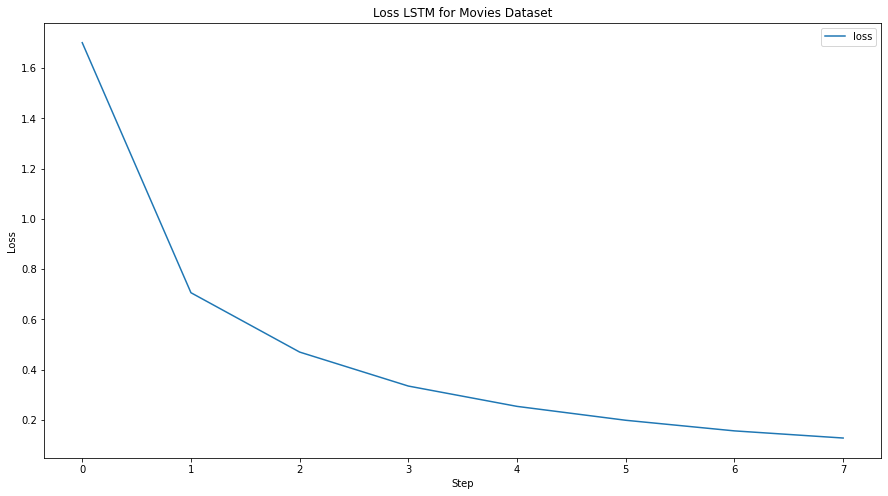

In [ ]:
fig, axs = plt.subplots(1,1)
path = '/content/drive/MyDrive/IAS/NLP_and_Web/report/training_logs_'+ movie_names[movie_index]+ '.csv'
plot_loss(path, axs, title='Loss LSTM for Movies Dataset')

###Average the Results

In [ ]:
def load_df(path):
    movie_name = path.split('/')[-1].replace('matrix_report_','').split('.')[0]
    #name = path.split('.')[0]
    df = pd.read_csv(path)
    df['movie_name'] = movie_name
    df = df.rename(columns={'Unnamed: 0': 'label'})
    return df

In [ ]:
report_file = ['TheWolfofWallStreet.csv', 'South_Park.csv', 'Pulp_Fiction.csv', 'Django_Unchained.csv', 'AmerricanHistoryX.csv', 'BlacKkKlansman.csv']

In [ ]:
dataframes = []
for report in report_file:
    df = load_df('/content/drive/MyDrive/IAS/NLP_and_Web/report/matrix_report_'+ report)
    dataframes.append(df)
result_df = pd.concat(dataframes)

In [ ]:
result_df

,label,precision,recall,f1-score,support,movie_name
0,normal,0.917102,0.992724,0.953416,2474.000000,TheWolfofWallStreet
1,offensive,0.953247,0.625213,0.755144,587.000000,TheWolfofWallStreet
2,hate,0.000000,0.000000,0.000000,2.000000,TheWolfofWallStreet
3,accuracy,0.921645,0.921645,0.921645,0.921645,TheWolfofWallStreet
4,macro avg,0.623450,0.539312,0.569520,3063.000000,TheWolfofWallStreet
5,weighted avg,0.923430,0.921645,0.914796,3063.000000,TheWolfofWallStreet
0,normal,0.914195,0.969663,0.941112,890.000000,South_Park
1,offensive,0.712871,0.496552,0.585366,145.000000,South_Park
2,hate,0.000000,0.000000,0.000000,11.000000,South_Park
3,accuracy,0.893881,0.893881,0.893881,0.893881,South_Park


In [ ]:
def get_precision_recall_f1(category):
    precision = result_df[result_df.label==category].precision.mean()
    recall = result_df[result_df.label==category].recall.mean()
    f1 = result_df[result_df.label==category]['f1-score'].mean()
    macro_avg_f1 = result_df[result_df.label=='macro avg']['f1-score'].mean()
    
    return {'label': category, 'precision': precision, 'recall': recall, 'f1': f1, 'macro_avg_f1':macro_avg_f1 }

In [ ]:
normal_dict = get_precision_recall_f1('normal')
offensive_dict = get_precision_recall_f1('offensive')
hate_dict = get_precision_recall_f1('hate')

In [ ]:
df_result = pd.DataFrame([normal_dict, offensive_dict, hate_dict])
df_result

,label,precision,recall,f1,macro_avg_f1
0,normal,0.922918,0.969716,0.945667,0.543193
1,offensive,0.620086,0.556788,0.574700,0.543193
2,hate,0.550000,0.064412,0.109213,0.543193


###Testing in HateXplain model